# MMM Demo Workbook

## Install dependencies

In [1]:
!pip install -q -U git+https://@github.com/griffin-analytics/griffin-mmm-demo.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 16.7 MB/s eta 0:00:00


In [2]:
%load_ext autoreload

from base_driver import MMMBaseDriver
from base_driver import utils as ut
from mmm import describe as dsc
from mmm import plot as mplt


## Inputs

In [3]:
%autoreload 2

driver = MMMBaseDriver(
    "demo_config.yml",
    "demo_data.xlsx",
    "holidays.xlsx")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpr_bfc6aj/efog7er_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr_bfc6aj/we12cut3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10778', 'data', 'file=/tmp/tmpr_bfc6aj/efog7er_.json', 'init=/tmp/tmpr_bfc6aj/we12cut3.json', 'output', 'file=/tmp/tmpr_bfc6aj/prophet_modelhkxnvq84/prophet_model-20241218093208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:32:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:32:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing feature: competitor_spend, impact: negative


DEBUG:cmdstanpy:input tempfile: /tmp/tmpr_bfc6aj/n7hir7ak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr_bfc6aj/gp2vvsun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32926', 'data', 'file=/tmp/tmpr_bfc6aj/n7hir7ak.json', 'init=/tmp/tmpr_bfc6aj/gp2vvsun.json', 'output', 'file=/tmp/tmpr_bfc6aj/prophet_modelvlcwv9p6/prophet_model-20241218093212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:32:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:32:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing feature: competitor_spend, impact: negative


## Preprocessing

In [4]:
ut.setup_logger()

<Logger cmdstanpy (WARNING)>

In [5]:
ut.set_style()

In [6]:
driver.check_quality()

([                 feature_0  feature_1  feature_2  feature_3  extra_feature_0  \
  feature_0             1.00      -0.03       0.27       0.22              NaN   
  feature_1            -0.03       1.00       0.67       0.07              NaN   
  feature_2             0.27       0.67       1.00       0.22              NaN   
  feature_3             0.22       0.07       0.22       1.00              NaN   
  extra_feature_0        NaN        NaN        NaN        NaN              NaN   
  extra_feature_1      -0.06       0.09      -0.01       0.27              NaN   
  extra_feature_2      -0.01       0.06      -0.09      -0.05              NaN   
  extra_feature_3      -0.21      -0.33      -0.50      -0.25              NaN   
  extra_feature_4       0.31       0.23       0.41       0.23              NaN   
  extra_feature_5       0.24      -0.01       0.16       0.16              NaN   
  extra_feature_6      -0.08      -0.05      -0.11       0.04              NaN   
  target        

In [7]:
high_var = driver.highlight_variances()
high_inf = driver.highlight_high_vif_values()
high_spf = driver.highlight_low_spend_fractions()
fig, corr_df = driver.plot_correlation()
all_mds_fig = driver.plot_all_media_spend()

## Main Driver

In [8]:
driver.main()

Creating output directory at /content/results...
Folder 'results' created or already exists.
Creation time (birth time) not available.
Training columns: Index(['date', 'covid_index', 'competitor_spend', 'promo_events',
       'media_cost_1', 'media_cost_2', 'media_cost_3', 'media_cost_4',
       'media_imp_1', 'media_imp_2', 'media_imp_3', 'media_imp_4', 'trend',
       'yearly', 'holidays', 'weekly'],
      dtype='object')
Configuration saved to /content/results/model_config.json


Output()

Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 37 divergences after tuning. Increase `target_accept` or reparameterize.


Visualizing the results...
Response curves data saved to /content/results/response_curves.csv


Output()

Using config: demo_config.yml, input file: demo_data.xlsx
Output written to /content/results/output.txt
Run ID: 20241218095446


'/content/results'

In [9]:
driver.compute_elpd(model_name=driver.run_id, results_dir="/content/results")

In [10]:
driver.save_posterior_samples(results_dir='/content/results')

Posterior samples saved to /content/results/trace.nc


In [11]:
driver.plot_posterior_distributions(results_dir='/content/results')

Beta channel data shape: (4, 2000, 4)
Data dimensions: ('chain', 'draw', 'channel')
Media spend posterior plots saved to /content/results/media_spend_posterior.png


,channel,mean,median,std,hdi_low,hdi_high,skewness,kurtosis
0,Media Channel 1,0.11,0.07,0.16,0.00,0.19,6.14,63.00
1,Media Channel 2,0.10,0.05,0.19,0.00,0.19,6.67,73.24
2,Media Channel 3,0.16,0.09,0.23,0.00,0.19,5.05,39.58
3,Media Channel 4,0.06,0.03,0.10,0.00,0.19,7.19,85.36


Output()

Output()

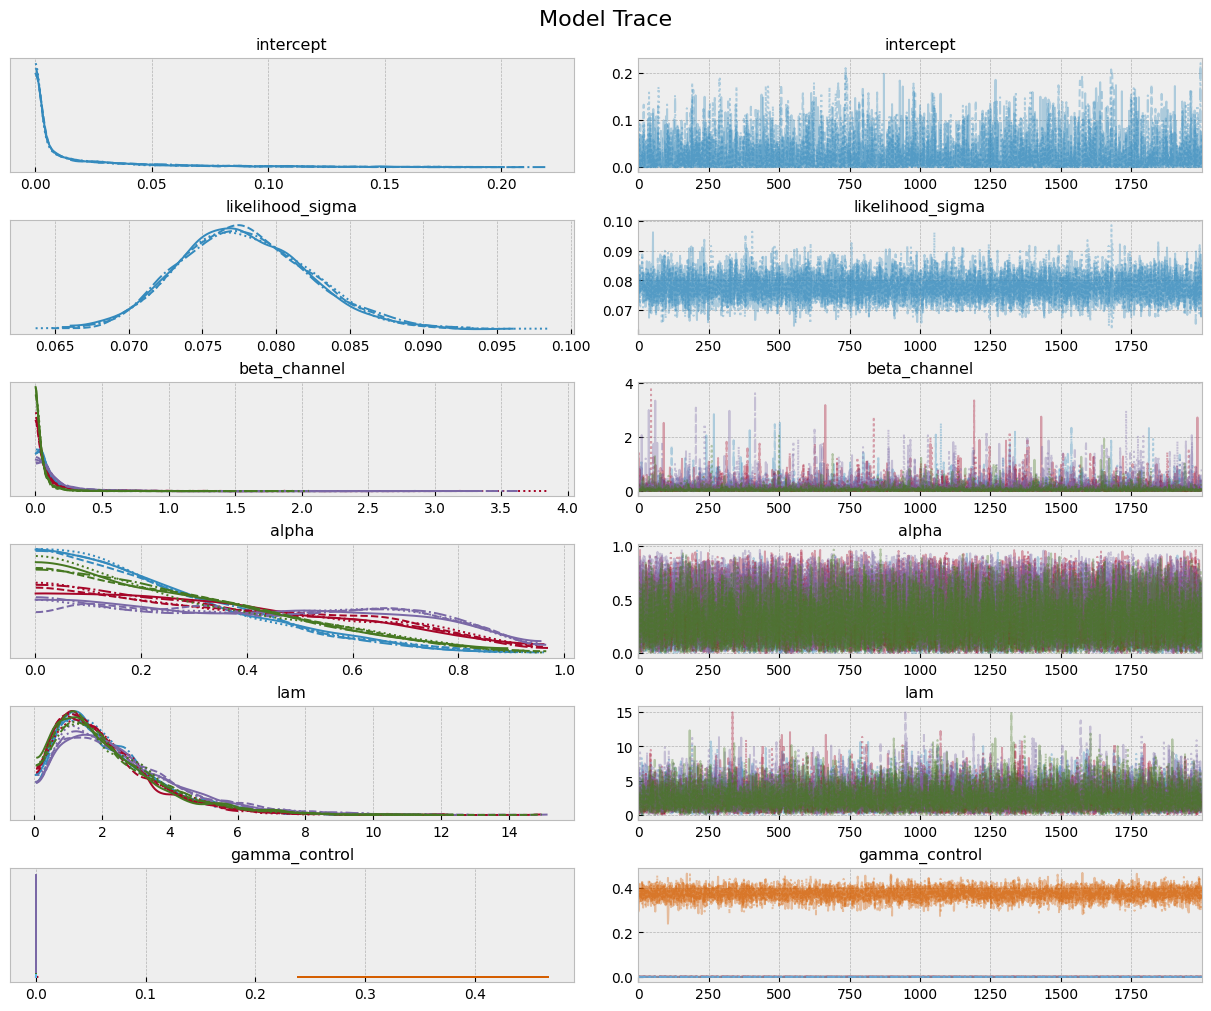

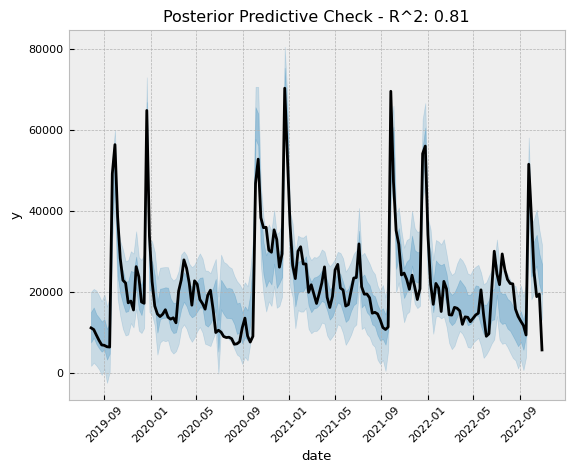

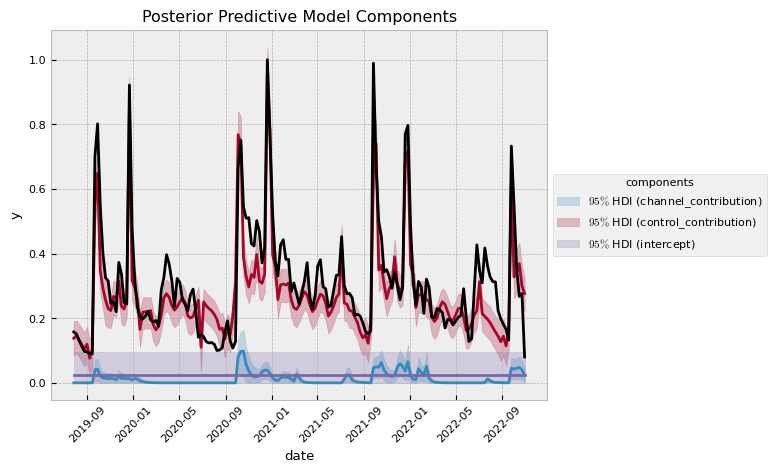

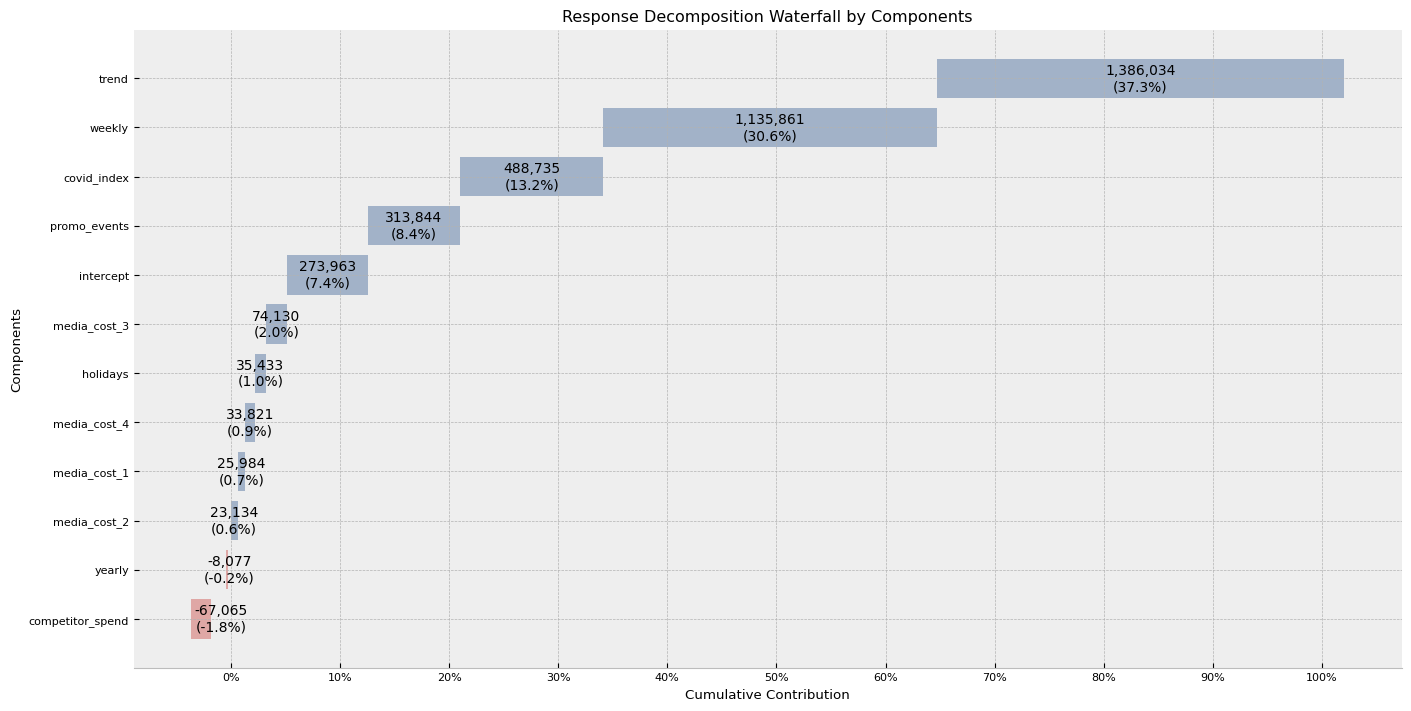

In [12]:
mdl_st = driver.plot_model_structure()
model_trace = driver.plot_model_trace()
r2_score = driver.calculate_train_r_squared()
posterior_predictive = driver.plot_posterior_predictive()
components_contribution = driver.plot_components_contributions()
waterfall_plot = driver.plot_waterfall_components_decomposition()

## Check Diagnostics

In [13]:
quick_stats = dsc.quick_stats(driver.model)

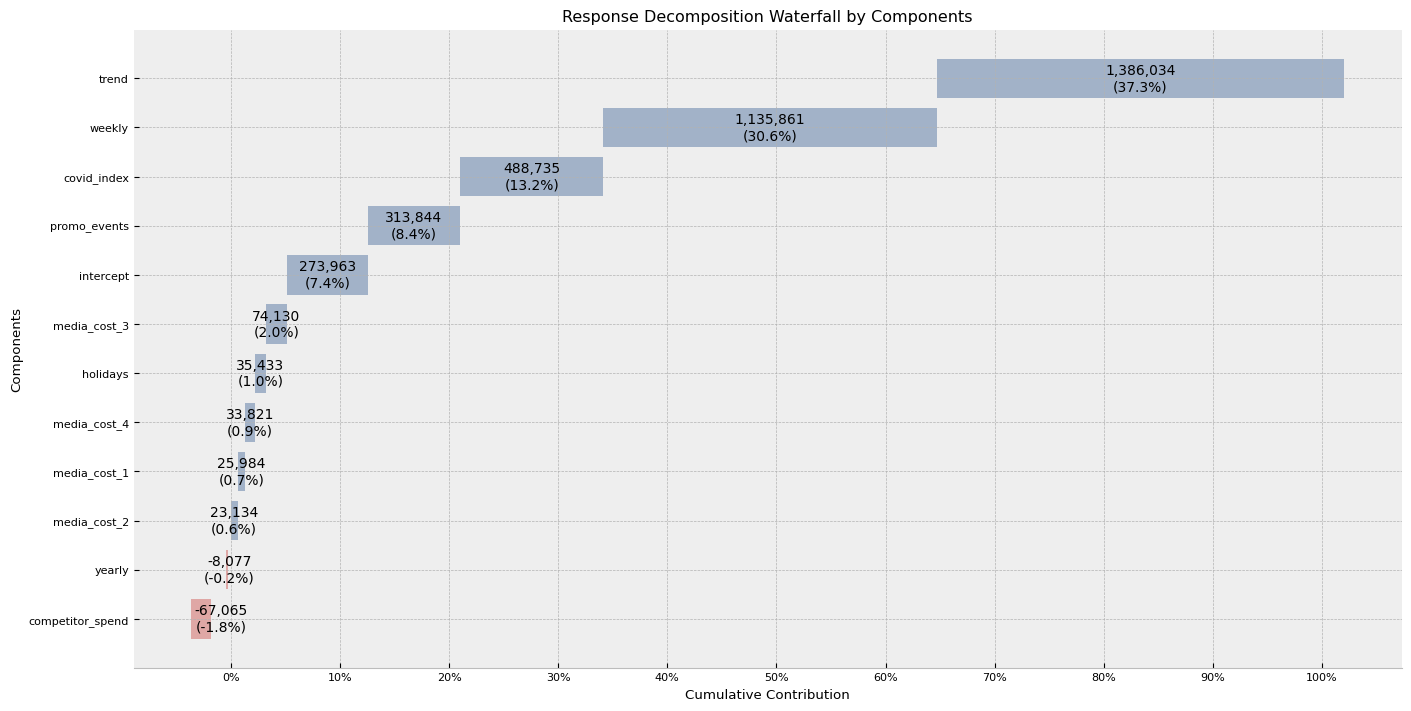

In [14]:
waterfall_plot

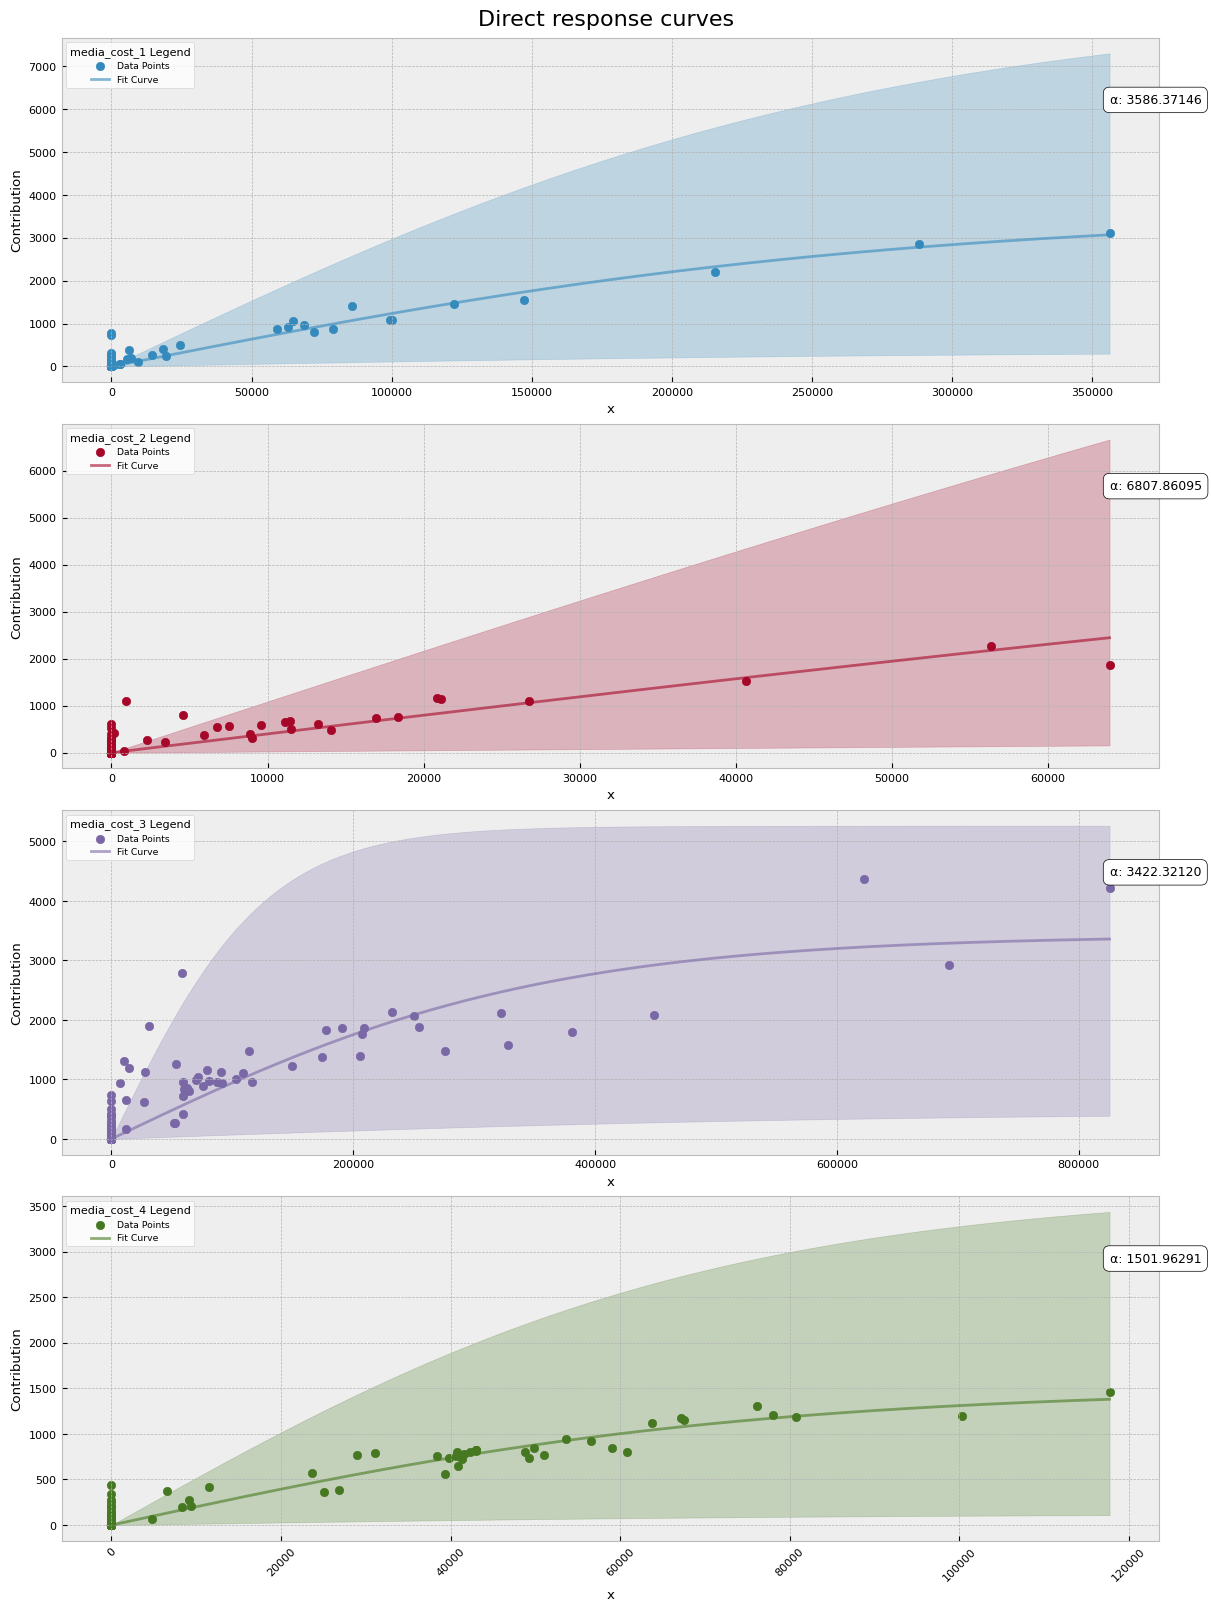

In [15]:
weekly_spend_curve = mplt.weekly_spend_by_channel(driver.model)

In [16]:
high_var

,geo_0
feature_0,0.747755
feature_1,0.527057
feature_2,0.300146
feature_3,0.264810
extra_feature_0,0.000000
extra_feature_1,0.322038
extra_feature_2,9597669376.000000
extra_feature_3,1531.390747
extra_feature_4,0.065251
extra_feature_5,0.002936


In [17]:
high_inf

,geo_0
feature_0,1.334927
feature_1,2.136184
feature_2,2.847985
feature_3,1.284496
extra_feature_0,391.954220
extra_feature_1,1.188885
extra_feature_2,1.122437
extra_feature_3,1.513580
extra_feature_4,1.480708
extra_feature_5,1.168456


In [18]:
high_spf

,fraction of spend
feature_0,0.162800
feature_1,0.032500
feature_2,0.652900
feature_3,0.151800


In [19]:
fig

In [20]:
corr_df

,Media Channel 1 volume,Media Channel 2 volume,Media Channel 3 volume,Media Channel 4 volume,subscribers
Media Channel 1 volume,1.00,-0.03,0.27,0.22,0.28
Media Channel 2 volume,-0.03,1.00,0.67,0.07,0.28
Media Channel 3 volume,0.27,0.67,1.00,0.22,0.46
Media Channel 4 volume,0.22,0.07,0.22,1.00,0.33
subscribers,0.28,0.28,0.46,0.33,1.00


In [21]:
all_mds_fig

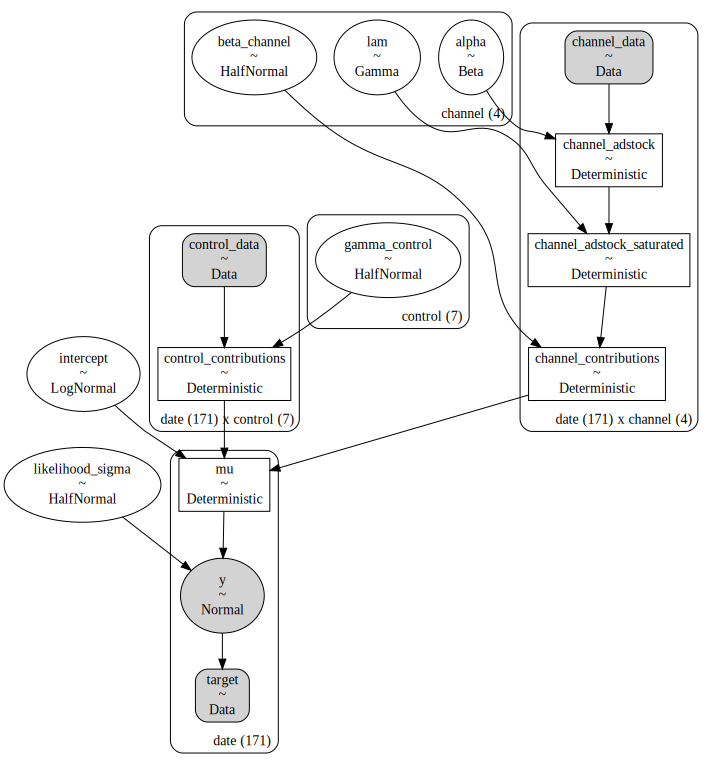

In [22]:
mdl_st

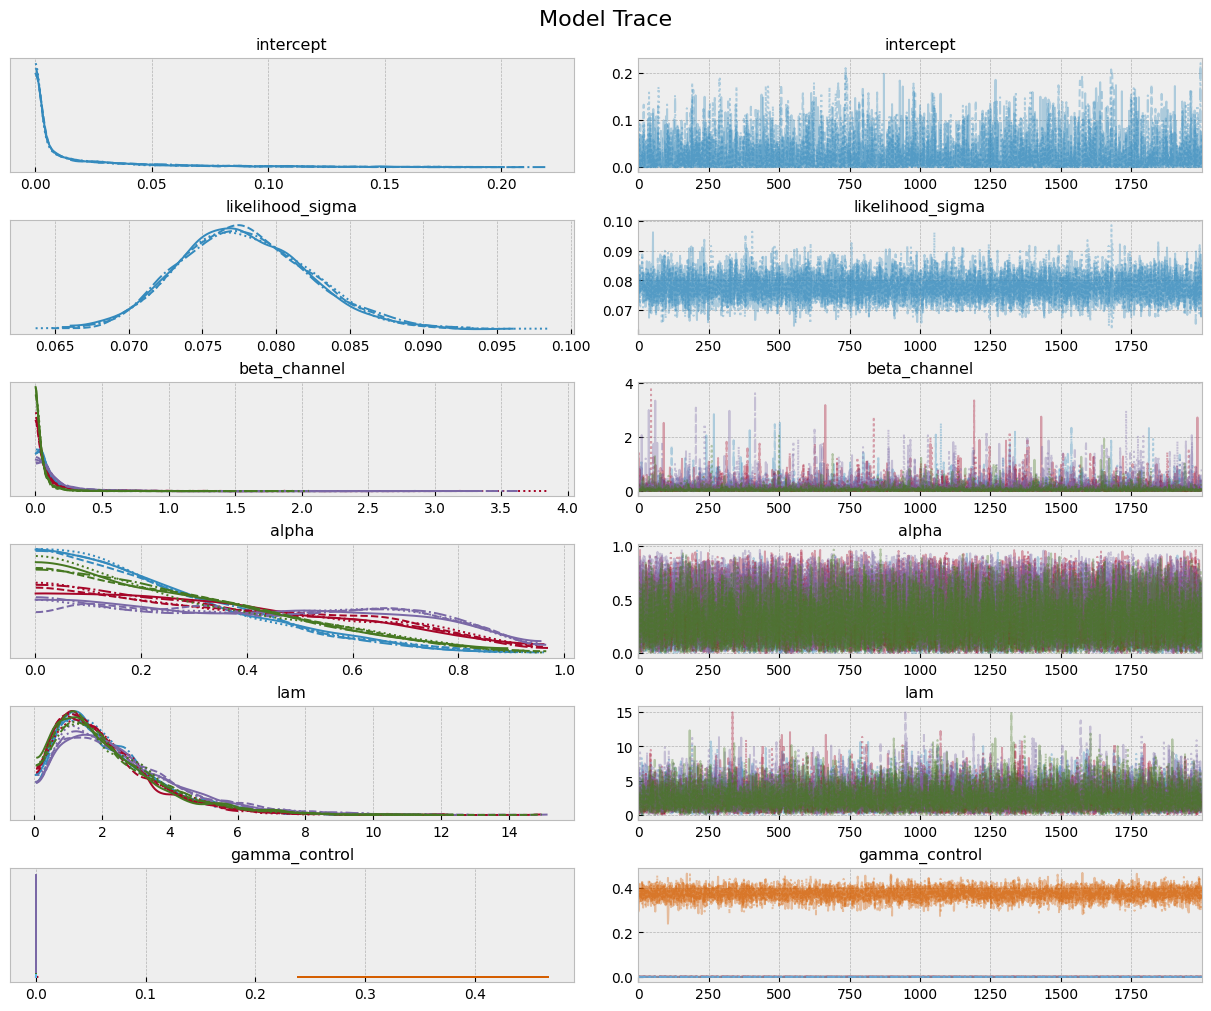

In [23]:
model_trace

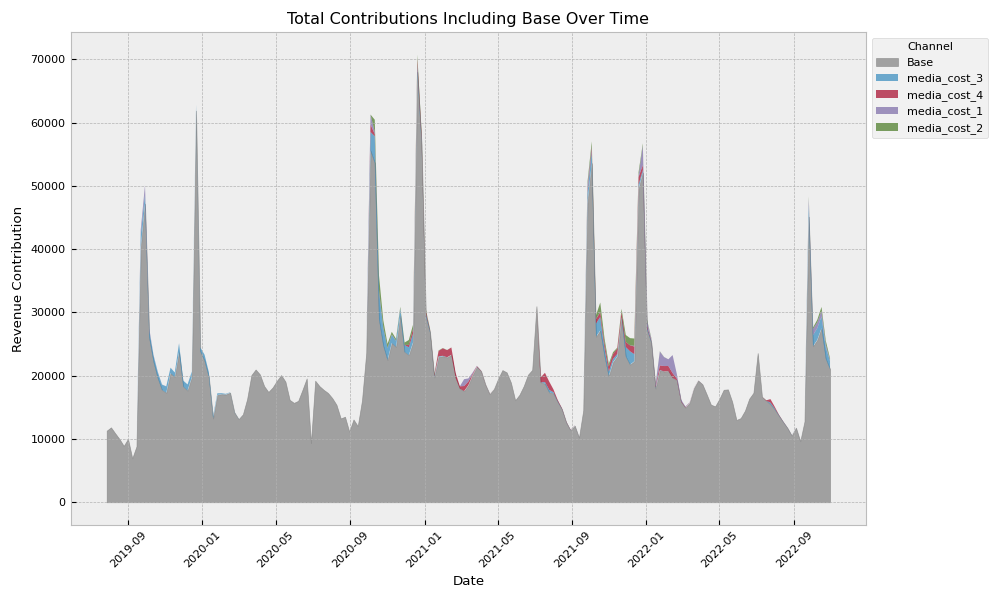

In [24]:
driver.display_image("weekly_media_and_baseline_contribution.png")

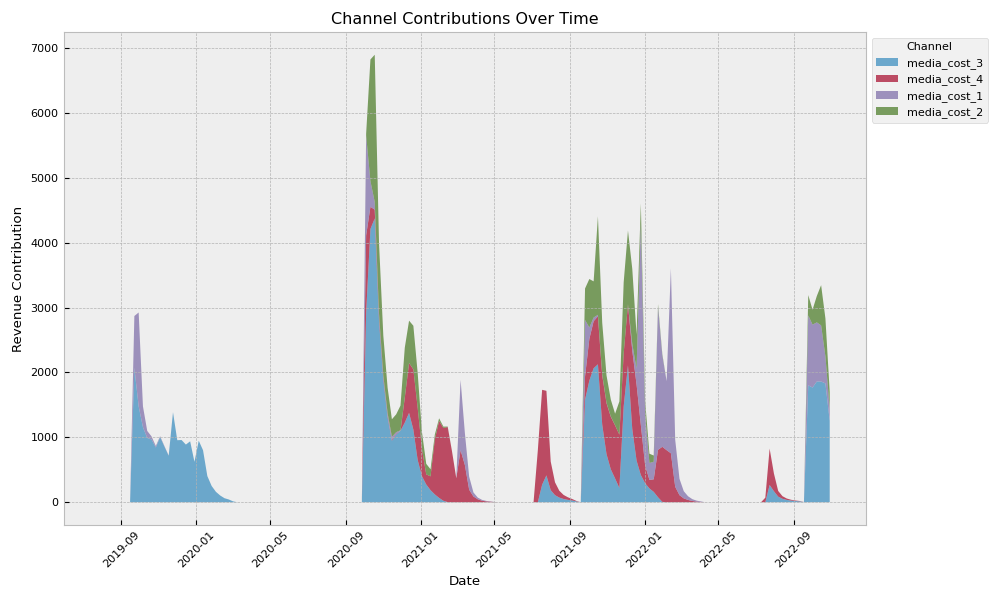

In [25]:
driver.display_image("weekly_media_contribution.png")

In [26]:
r2_score

0.8103052012113416

In [27]:
driver.per_observation_df

,Media Channel 1 volume,Media Channel 2 volume,Media Channel 3 volume,Media Channel 4 volume,Media Channel 1 cost,Media Channel 2 cost,Media Channel 3 cost,Media Channel 4 cost,weekly,covid_index,competitor_spend,yearly,promo_events,trend,holidays,subscribers
2019-07-28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"5,422.23",0.00,"-310,951.00","-3,204.29",0.00,"12,864.02",0.00,"11,071.00"
2019-08-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"5,422.23",0.00,"-12,355.00","-4,279.63",0.00,"12,879.59",0.00,"10,661.00"
2019-08-11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"5,422.23",0.00,"-4,631.00","-5,427.91",0.00,"12,895.16",0.00,"9,291.00"
2019-08-18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"5,422.23",0.00,"-8,491.00","-6,458.77",0.00,"12,910.73",0.00,"7,986.00"
2019-08-25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"5,422.23",0.00,"-17,718.00","-7,666.12",0.00,"12,926.30",0.00,"6,860.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-02,"3,487,628.00",0.00,"68,008,304.00",0.00,"68,821.00","3,404.00","206,882.00",0.00,"5,422.23",16.00,"-342,386.00","9,555.46",0.00,"15,449.33",0.00,"38,721.00"
2022-10-09,"3,400,749.00","68,861.00","64,234,592.00",0.00,"62,841.00","8,846.00","209,232.02",0.00,"5,422.23",25.00,"-134,755.00","13,311.04",0.00,"15,464.91","-3,617.91","24,846.00"
2022-10-16,"3,276,196.00","145,960.00","55,358,616.00",0.00,"59,020.00","13,257.00","190,378.02",0.00,"5,422.23",25.00,"-233,021.00","11,606.24",0.00,"15,480.48",0.00,"18,798.00"
2022-10-23,"1,686,683.00","80,685.00","46,538,256.00",0.00,"18,531.00","9,550.00","177,074.02",0.00,"5,422.23",25.00,"-378,224.00","6,832.06",0.00,"15,496.06",0.00,"19,431.00"


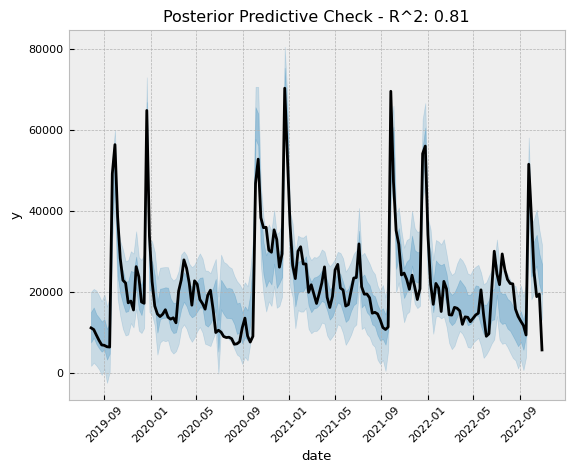

In [28]:
posterior_predictive

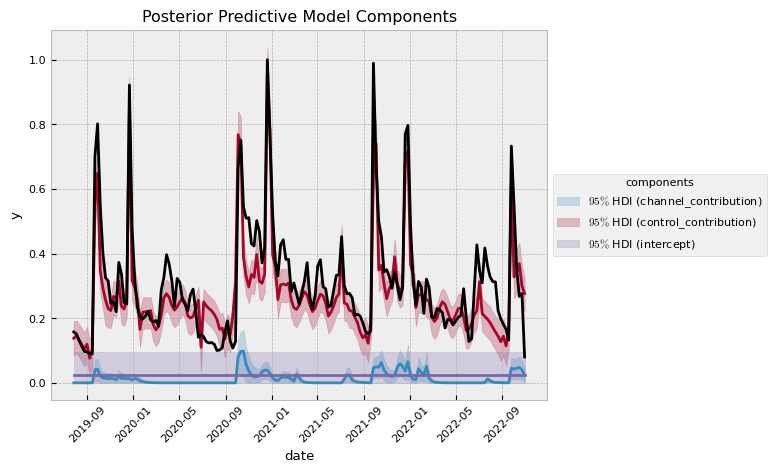

In [29]:
components_contribution

In [30]:
driver.data_to_fit.to_data_frame()

(            Media Channel 1 volume  Media Channel 2 volume  \
 2019-07-28                    0.00                    0.00   
 2019-08-04                    0.00                    0.00   
 2019-08-11                    0.00                    0.00   
 2019-08-18                    0.00                    0.00   
 2019-08-25                    0.00                    0.00   
 ...                            ...                     ...   
 2022-10-02                    1.84                    0.00   
 2022-10-09                    1.79                    0.07   
 2022-10-16                    1.73                    0.15   
 2022-10-23                    0.89                    0.09   
 2022-10-30                    0.26                    0.00   
 
             Media Channel 3 volume  Media Channel 4 volume  \
 2019-07-28                    0.00                    0.00   
 2019-08-04                    0.00                    0.00   
 2019-08-11                    0.00                  

In [31]:
quick_stats

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median
intercept,0.02,0.04,0.00,0.07,0.00,0.00,"3,576.00","3,313.00",1.00,0.01
likelihood_sigma,0.08,0.00,0.07,0.09,0.00,0.00,"7,284.00","5,698.00",1.00,0.08
beta_channel[media_cost_1],0.11,0.16,0.00,0.24,0.00,0.00,"4,273.00","4,264.00",1.00,0.07
beta_channel[media_cost_2],0.10,0.19,0.00,0.23,0.00,0.00,"3,582.00","3,879.00",1.00,0.04
beta_channel[media_cost_3],0.16,0.23,0.00,0.35,0.00,0.00,"2,833.00","3,521.00",1.00,0.09
beta_channel[media_cost_4],0.06,0.10,0.00,0.12,0.00,0.00,"3,602.00","4,172.00",1.00,0.03
alpha[media_cost_1],0.24,0.18,0.00,0.51,0.00,0.00,"5,538.00","2,823.00",1.00,0.20
alpha[media_cost_2],0.36,0.24,0.00,0.72,0.00,0.00,"5,670.00","4,090.00",1.00,0.32
alpha[media_cost_3],0.42,0.26,0.00,0.78,0.00,0.00,"4,440.00","4,128.00",1.00,0.42
alpha[media_cost_4],0.28,0.21,0.00,0.59,0.00,0.00,"7,716.00","4,305.00",1.00,0.24


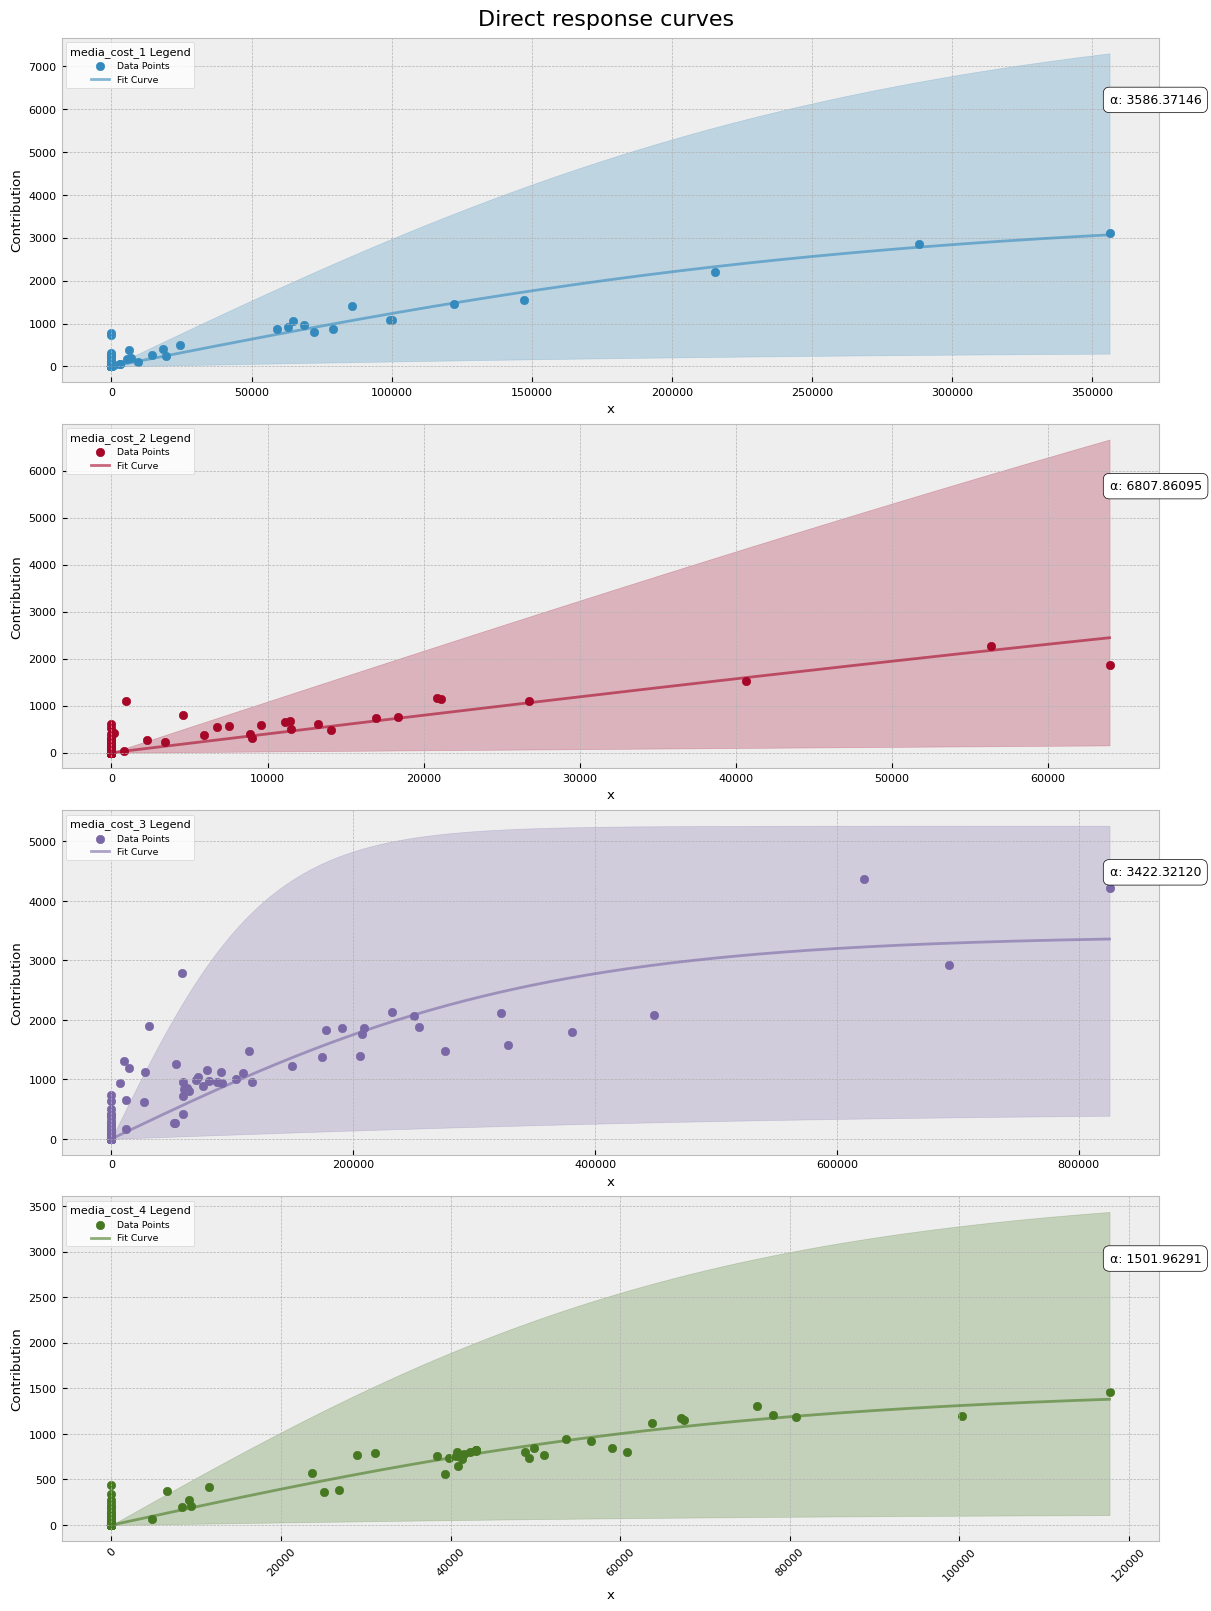

In [32]:
weekly_spend_curve

Response curves data saved to ./results/response_curves.csv


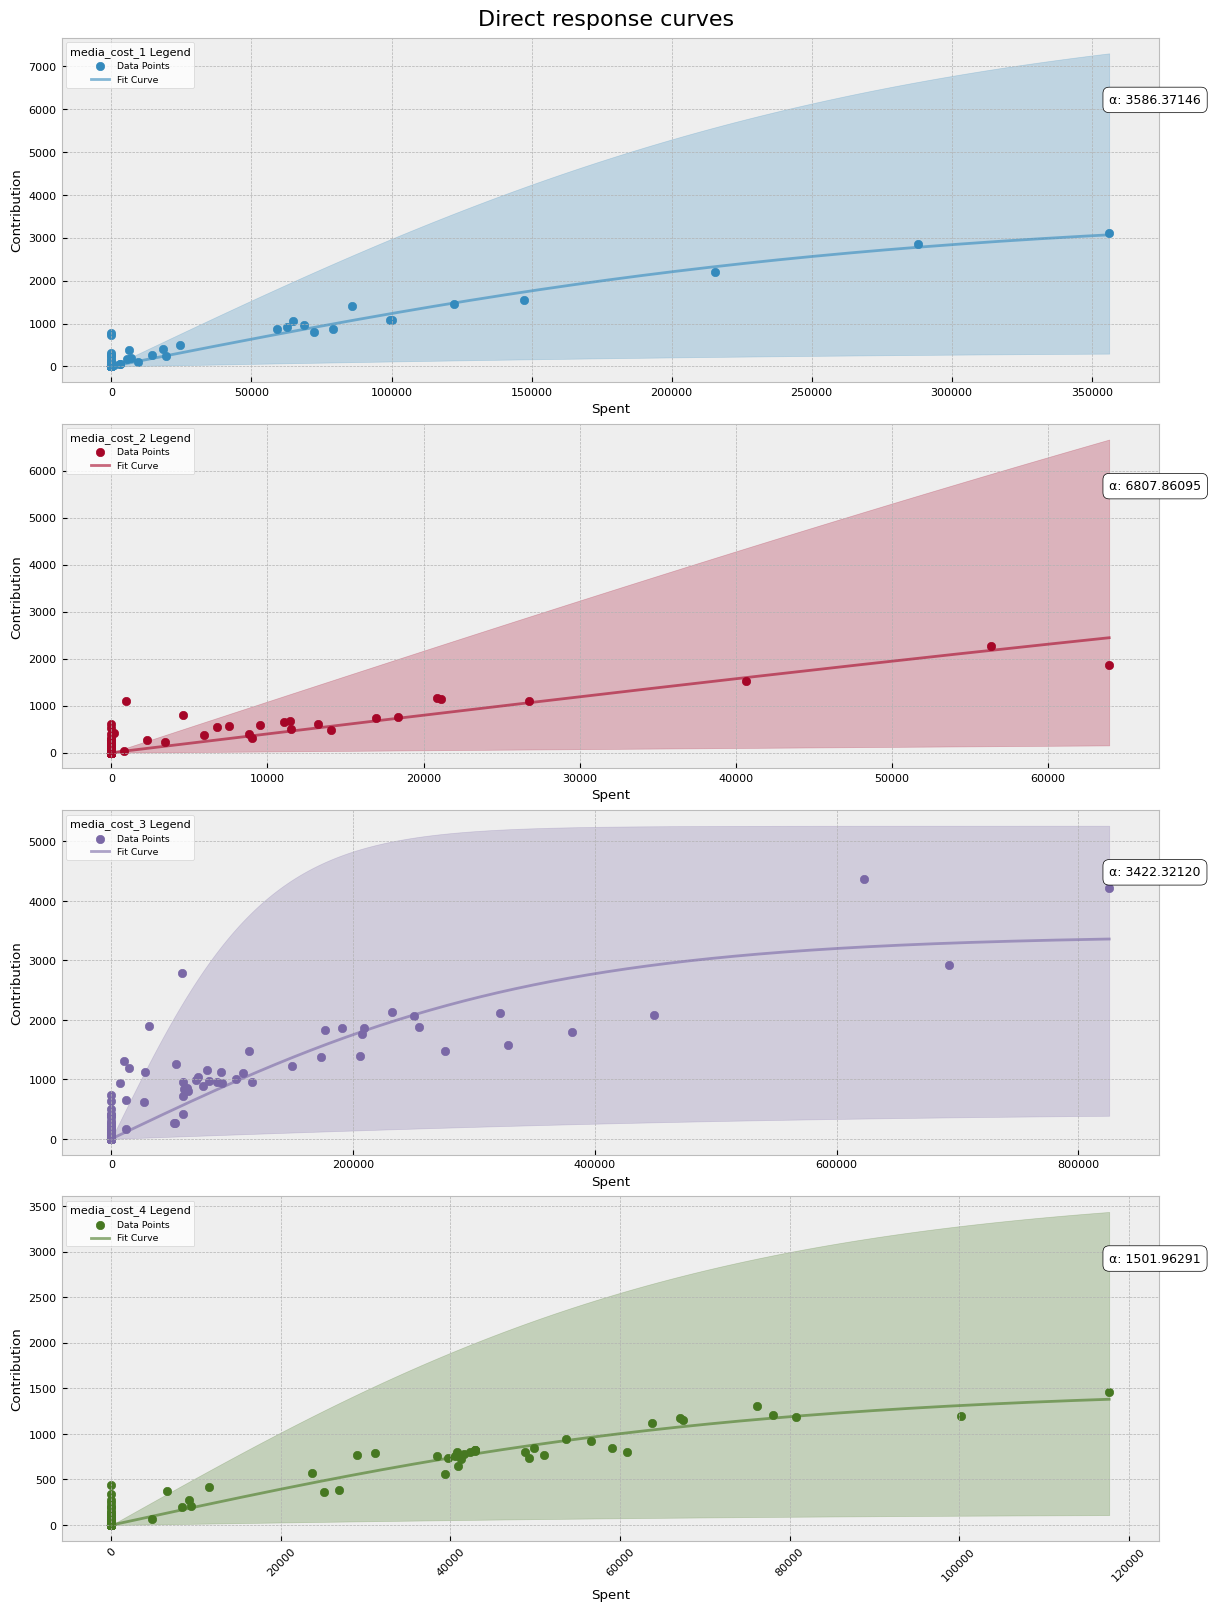

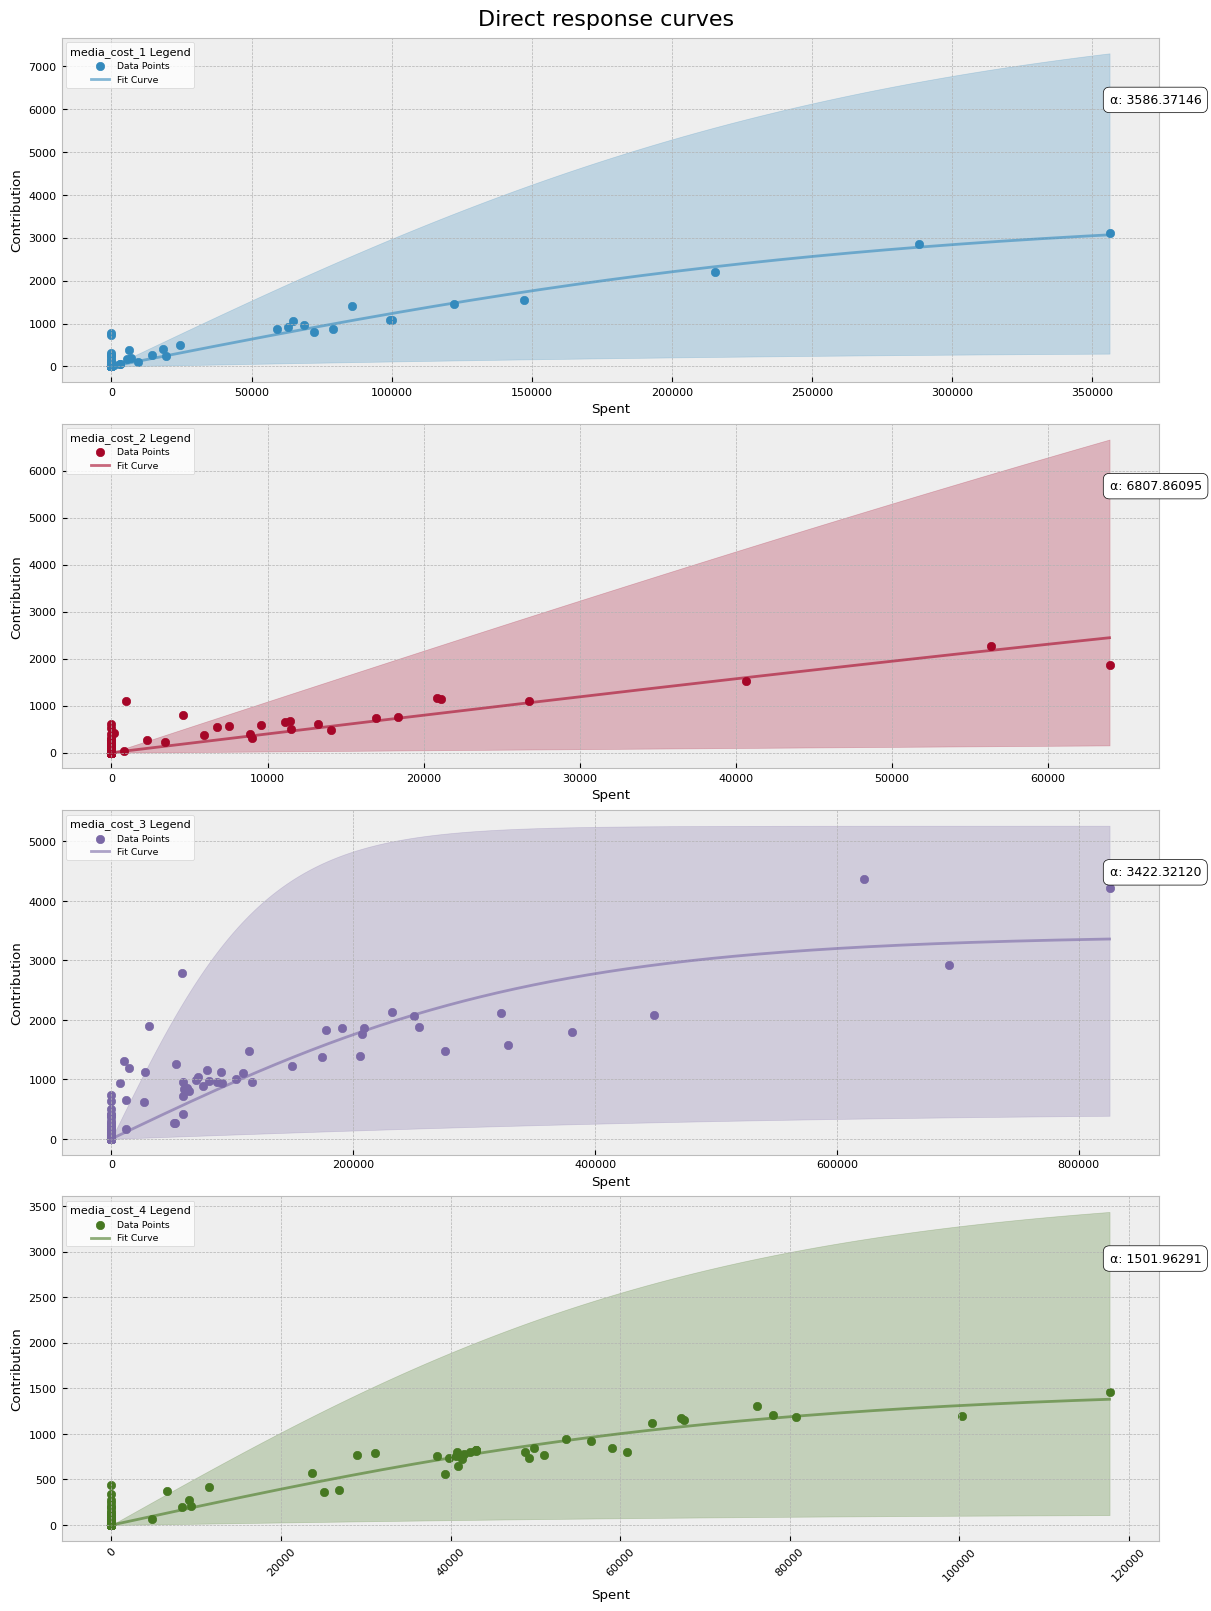

In [33]:
model = driver.model
model.plot_direct_contribution_curves(
    show_fit=True,
    method="sigmoid",
    export_curves=True,  # save curves as numerical outputs
    results_dir='./results'
)

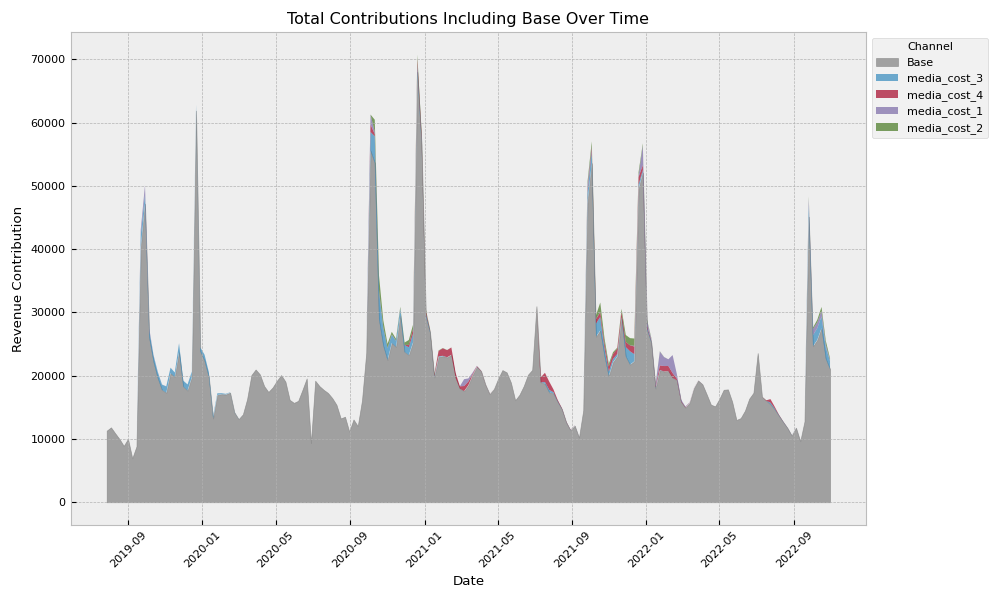

In [34]:
driver.display_image("weekly_media_and_baseline_contribution.png")

## Optimize marketing budget

### Define Optim Function

In [35]:
"""Budget optimization module."""
from typing import Dict, List, Optional, Tuple

import mmm.utils as ut
import scipy.optimize as sopt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('bmh')


def calculate_expected_contribution(
    method: str,
    parameters: Dict[str, Tuple[float, float]],
    budget: Dict[str, float],
) -> Dict[str, float]:
    """
    Calculate expected contributions using the specified model.

    This function calculates the expected contributions for each channel
    based on the chosen model. The selected model can be either the Michaelis-Menten
    model or the sigmoid model, each described by specific parameters.
    As the allocated budget varies, the expected contribution is computed according
    to the chosen model.

    Parameters
    ----------
    method : str
        The model to use for contribution estimation. Choose from 'michaelis-menten' or 'sigmoid'.
    parameters : Dict
        Model-specific parameters for each channel. For 'michaelis-menten', each entry is a tuple (L, k) where:
        - L is the maximum potential contribution.
        - k is the budget at which the contribution is half of its maximum.

        For 'sigmoid', each entry is a tuple (alpha, lam) where:
        - alpha controls the slope of the curve.
        - lam is the budget at which the curve transitions.
    budget : Dict
        The total budget.

    Returns
    -------
    Dict
        A dictionary with channels as keys and their respective contributions as values.
        The key 'total' contains the total expected contribution across all channels.

    Raises
    ------
    ValueError
        If the specified `method` is not recognized.
    """

    total_expected_contribution = 0.0
    contributions = {}

    for channel, channe_budget in budget.items():
        if method == "michaelis-menten":
            L, k = parameters[channel]
            contributions[channel] = ut.michaelis_menten(channe_budget, L, k)

        elif method == "sigmoid":
            alpha, lam = parameters[channel]
            contributions[channel] = ut.sigmoid_saturation(channe_budget, alpha, lam)

        else:
            raise ValueError("`method` must be either 'michaelis-menten' or 'sigmoid'.")

        total_expected_contribution += contributions[channel]

    contributions["total"] = total_expected_contribution

    return contributions


def objective_distribution(
    x: List[float],
    method: str,
    channels: List[str],
    parameters: Dict[str, Tuple[float, float]],
) -> float:
    """
    Compute the total contribution for a given budget distribution.

    This function calculates the negative sum of contributions for a proposed budget
    distribution using the Michaelis-Menten model. This value will be minimized in
    the optimization process to maximize the total expected contribution.

    Parameters
    ----------
    x : List of float
        The proposed budget distribution across channels.
    channels : List of str
        The List of channels for which the budget is being optimized.
    parameters : Dict
        Michaelis-Menten parameters for each channel as described in `calculate_expected_contribution`.

    Returns
    -------
    float
        Negative of the total expected contribution for the given budget distribution.
    """

    sum_contributions = 0.0

    for channel, budget in zip(channels, x):
        if method == "michaelis-menten":
            L, k = parameters[channel]
            sum_contributions += ut.michaelis_menten(budget, L, k)

        elif method == "sigmoid":
            alpha, lam = parameters[channel]
            sum_contributions += ut.sigmoid_saturation(budget, alpha, lam)

        else:
            raise ValueError("`method` must be either 'michaelis-menten' or 'sigmoid'.")

    return -1 * sum_contributions


def optimize_budget_distribution(
    method: str,
    total_budget: int,
    budget_ranges: Optional[Dict[str, Tuple[float, float]]],
    parameters: Dict[str, Tuple[float, float]],
    channels: List[str],
) -> Dict[str, float]:
    """
    Optimize the budget allocation across channels to maximize total contribution.

    Using the Michaelis-Menten or Sigmoid function, this function seeks the best budget distribution across
    channels that maximizes the total expected contribution.

    This function leverages the Sequential Least Squares Quadratic Programming (SLSQP) optimization
    algorithm to find the best budget distribution across channels that maximizes the total
    expected contribution based on the Michaelis-Menten or Sigmoid functions.

    The optimization is constrained such that:
    1. The sum of budgets across all channels equals the total available budget.
    2. The budget allocated to each individual channel lies within its specified range.

    The SLSQP method is particularly suited for this kind of problem as it can handle
    both equality and inequality constraints.

    Parameters
    ----------
    total_budget : int
        The total budget to be distributed across channels.
    budget_ranges : Dict or None
        An optional dictionary defining the minimum and maximum budget for each channel.
        If not provided, the budget for each channel is constrained between 0 and its L value.
    parameters : Dict
        Michaelis-Menten parameters for each channel as described in `calculate_expected_contribution`.
    channels : list of str
        The list of channels for which the budget is being optimized.

    Returns
    -------
    Dict
        A dictionary with channels as keys and the optimal budget for each channel as values.
    """

    # Check if budget_ranges is the correct type
    if not isinstance(budget_ranges, (dict, type(None))):
        raise TypeError("`budget_ranges` should be a dictionary or None.")

    if budget_ranges is None:
        budget_ranges = {
            channel: (0, min(total_budget, parameters[channel][0]))
            for channel in channels
        }

    initial_guess = [total_budget // len(channels)] * len(channels)

    bounds = [budget_ranges[channel] for channel in channels]

    constraints = {"type": "eq", "fun": lambda x: np.sum(x) - total_budget}

    result = sopt.minimize(
        lambda x: objective_distribution(x, method, channels, parameters),
        initial_guess,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
    )

    return {channel: budget for channel, budget in zip(channels, result.x)}


def budget_allocator(
    method: str,
    total_budget: int,
    channels: List[str],
    parameters: Dict[str, Tuple[float, float]],
    budget_ranges: Optional[Dict[str, Tuple[float, float]]],
) -> pd.DataFrame:
    """
    Allocate the optimal marketing budget across multiple channels based on specified optimization criteria.

    This function determines the best way to distribute a given total marketing budget across different channels
    to maximize the expected contribution to a desired outcome, such as conversions or revenue. The allocation is
    guided by a chosen optimization method (e.g., sigmoid, linear), and considers parameters that describe the
    relationship between spend and contribution for each channel. The function also respects any predefined budget
    ranges for each channel, ensuring that the allocation stays within practical limits.

    ### Key Components:
    1. **Optimization Method:**
       - The `method` parameter specifies the mathematical approach used to optimize the budget allocation.
       - Common methods include sigmoid or linear models, which define how spending impacts contribution across channels.

    2. **Budget Constraints:**
       - `total_budget` sets the overall limit for how much can be allocated across all channels.
       - `budget_ranges` optionally allows setting specific minimum and maximum bounds for individual channels, ensuring
         that the budget distribution adheres to strategic constraints or real-world limitations.

    3. **Channel Parameters:**
       - The `parameters` dictionary contains key-value pairs where each key is a channel name, and each value is a tuple
         representing the parameters (e.g., alpha, lambda for sigmoid) that define the spend-contribution curve for that channel.
       - These parameters are essential for calculating how efficiently each dollar spent on a channel converts into the desired outcome.

    4. **Output:**
       - The function returns a DataFrame that includes both the `optimal_budget` allocation for each channel and the
         `estimated_contribution` resulting from this allocation.
       - This output enables data-driven decision-making, allowing marketers to see the expected returns for each channel
         and adjust their strategies accordingly.

    ### Parameters:
    - `method` (str):
        - The optimization method to be used (e.g., 'sigmoid', 'linear').
        - This method dictates how the relationship between spend and contribution is modeled.
    - `total_budget` (int):
        - The total budget available for allocation across all channels.
        - This budget is distributed among the channels in a way that maximizes the overall contribution.
    - `channels` (List[str]):
        - A list of channel names that represent the marketing channels available for budget allocation.
        - Each channel in this list should have corresponding parameters defined in the `parameters` dictionary.
    - `parameters` (Dict[str, Tuple[float, float]]):
        - A dictionary where each key is a channel name and each value is a tuple representing the parameters for
          that channel’s spend-contribution curve.
        - These parameters guide the optimization process by defining how effective each dollar of spend is on a given channel.
    - `budget_ranges` (Optional[Dict[str, Tuple[float, float]]]):
        - An optional dictionary where each key is a channel name and each value is a tuple specifying the minimum and
          maximum budget that can be allocated to that channel.
        - If provided, these ranges ensure the budget allocation stays within practical or strategic limits.
    """

    optimal_budget = optimize_budget_distribution(
        method=method,
        total_budget=total_budget,
        budget_ranges=budget_ranges,
        parameters=parameters,
        channels=channels,
    )

    expected_contribution = calculate_expected_contribution(
        method=method, parameters=parameters, budget=optimal_budget
    )

    optimal_budget.update({"total": sum(optimal_budget.values())})

    return pd.DataFrame(
        {
            "estimated_contribution": expected_contribution,
            "optimal_budget": optimal_budget,
        }
    )

def get_lower_and_upper_bounds(media, n_time_periods, lower_pct, upper_pct):
    """
    Calculate dynamic lower and upper bounds for media spend based on historical data and specified adjustment percentages.

    This function determines the permissible range (lower and upper bounds) for future media spending by analyzing historical
    spending patterns. The bounds are calculated as a percentage adjustment from the mean historical spend, providing a flexible
    framework for budgeting that accounts for possible variations in spend while ensuring it stays within realistic limits.

    ### Key Components:
    1. **Historical Media Spend Analysis:**
       - The function begins by calculating the mean spend for each media channel over the historical period provided.
       - This mean serves as the baseline for determining future spend bounds, ensuring that projections are grounded in actual
         historical performance.

    2. **Dynamic Bound Adjustment:**
       - The lower and upper bounds are calculated by applying the `lower_pct` and `upper_pct` adjustments to the mean spend.
       - `lower_pct` defines the percentage by which the spend can decrease from the mean, while `upper_pct` defines the
         percentage by which it can increase.
       - The bounds are scaled by the number of time periods (`n_time_periods`) to reflect the cumulative effect over the
         optimization horizon.

    3. **Constraints and Flexibility:**
       - The lower bounds are capped at zero to prevent negative spend values, ensuring practical and realistic budget constraints.
       - The resulting bounds provide flexibility in budget allocation, allowing for increased spending in high-performing
         channels while capping potential overspend in others.

    ### Parameters:
    - `media` (pd.DataFrame):
        - A DataFrame containing historical spending data for each media channel.
        - Each column corresponds to a media channel, and each row represents a historical time period.
    - `n_time_periods` (int):
        - The number of future periods (e.g., weeks, months) for which the bounds should be calculated.
        - This parameter scales the bounds to ensure they are applicable over the entire projection horizon.
    - `lower_pct` (np.ndarray):
        - An array of percentage values representing the allowable decrease from the mean spend for each media channel.
        - Each value corresponds to a specific media channel and defines the lower bound as a percentage below the mean.
    - `upper_pct` (np.ndarray):
        - An array of percentage values representing the allowable increase from the mean spend for each media channel.
        - Each value defines the upper bound as a percentage above the mean for its respective channel.

    ### Returns:
    - `Tuple[np.ndarray, np.ndarray]`:
        - A tuple containing two numpy arrays: `lower_bounds` and `upper_bounds`.
        - `lower_bounds` represents the calculated lower bounds for each media channel, scaled by `n_time_periods`.
        - `upper_bounds` represents the calculated upper bounds for each media channel, also scaled by `n_time_periods`.

    """
    mean_data = media.mean(axis=0)
    lower_bounds = np.maximum(mean_data * (1 - lower_pct), 0)
    upper_bounds = mean_data * (1 + upper_pct)

    return (lower_bounds * n_time_periods, upper_bounds * n_time_periods)

def calculate_total_budget(mean_costs, n_time_periods):
    """
    Calculate the total marketing budget required for a specified number of future time periods.

    This function computes the total budget necessary to sustain marketing activities across various channels over a defined
    number of time periods (e.g., months, quarters). The budget is calculated based on the average historical spending for
    each media channel, scaled by the number of time periods for which the budget needs to be projected.

    Key Considerations:
    1. **Mean Media Costs:**
       - The `mean_costs` parameter represents the average historical spending per time period for each media channel.
       - This array typically reflects the mean of past expenditures, providing a baseline for projecting future budget needs.

    2. **Time Period Scaling:**
       - The `n_time_periods` parameter determines how many future periods the total budget should cover.
       - By multiplying the sum of the mean costs by the number of periods, the function scales the budget to ensure it supports
         sustained marketing efforts over the desired time horizon.

    3. **Budget Allocation Assumptions:**
       - The calculated budget assumes a consistent spending pattern across the future periods, based on the historical averages.
       - This approach is useful for planning purposes, especially when forecasting the financial requirements for maintaining
         or scaling marketing activities over time.

    ### Parameters:
    - `mean_costs` (np.ndarray):
        - An array containing the average historical costs for each media channel.
        - Each element in the array corresponds to a specific channel and represents the mean cost over past time periods.
    - `n_time_periods` (int):
        - The number of future time periods for which the total budget is being calculated.
        - This could be any unit of time, such as months or quarters, depending on the context of the optimization.

    ### Returns:
    - `float`:
        - The total budget required to cover the specified number of time periods, calculated as the sum of mean costs
          across all media channels, scaled by `n_time_periods`.
        - This scalar value represents the overall financial commitment needed to sustain the marketing strategy over
          the defined future periods.
    """
    return np.sum(mean_costs) * n_time_periods


def optimize_marketing_budget(model, data, config, results_dir,total_budget=None, frequency='M', n_time_periods=1):
    """
    Optimize the allocation of a marketing budget across various channels using a fitted marketing mix model and historical data.

    This function performs budget optimization by leveraging a calibrated marketing mix model to maximize the expected contribution
    to the overall marketing objective (e.g., sales, conversions) given a specified total budget. The process involves aggregating
    historical spending data at a chosen frequency (e.g., monthly, quarterly), defining dynamic budget bounds based on historical
    spending patterns, and optimizing budget allocations using a non-linear optimization approach.

    Key Steps:
    1. **Data Aggregation:**
       - Historical media spending data is aggregated according to the specified time frequency (e.g., 'M' for monthly, 'Q' for quarterly).
       - This aggregation helps to smooth out fluctuations and focus on broader spending trends over time, which are more indicative
         of strategic budget adjustments.

    2. **Budget Bound Calculation:**
       - For each media channel, dynamic lower and upper bounds for spending are calculated based on historical spending patterns.
       - These bounds are defined as a percentage deviation from the historical averages, allowing the optimization to explore budget
         allocations within realistic limits while considering potential scaling up or down.

    3. **Sigmoid Function Optimization:**
       - The function utilizes a sigmoid response curve to model the diminishing returns on spending, which is a common phenomenon in
         marketing where additional spending leads to progressively smaller gains.
       - The sigmoid parameters for each channel are estimated using the fitted model, capturing the relationship between spending and
         the marketing objective.

    4. **Optimization Process:**
       - A constrained optimization algorithm is employed to maximize the expected contribution to the marketing objective under the
         given budget constraints.
       - The optimization considers both the total budget available and the channel-specific budget bounds, aiming to allocate the budget
         where it is expected to yield the highest return.

    5. **Scenario Analysis:**
       - The function compares the optimized budget allocation against the initial scenario (i.e., the historical spending pattern).
       - The comparison is visualized to highlight potential improvements in marketing performance due to the optimized allocation.

    6. **Result Visualization and Saving:**
       - The optimized budget scenario, along with the initial budget scenario, is plotted for easy comparison.
       - The visualization is saved as an image file in the specified directory for reporting and further analysis.

    Parameters
    ----------
    model : PyMC-Marketing model
        The already fitted marketing mix model that will be used to optimize the budget.

    data : pd.DataFrame
        A DataFrame containing historical spending data. It must include a 'date' column and columns corresponding
        to each media channel specified in the configuration.

    config : dict
        A dictionary containing configuration data for media channels. This should include the names of the columns
        in the data that correspond to media spending.

    results_dir : str
        The directory where the optimization results, including plots, will be saved.

    total_budget : float, optional
        The total marketing budget to be allocated across the channels. If not provided, it will be calculated based
        on the average historical spending and the number of periods to optimize.

    frequency : str, optional
        The frequency for aggregating the spending data. Typical values are 'M' for monthly, 'Q' for quarterly, and
        'W' for weekly. Defaults to 'M' (monthly).

    n_time_periods : int, optional
        The number of future time periods (based on the specified frequency) for which the budget is to be optimized.
        Defaults to 1.

    Returns
    -------
    None
        The function does not return any value. It saves a plot of the optimized budget scenario compared to the
        initial scenario in the specified results directory.

    Notes
    -----
    - The optimization is based on a sigmoid function fitted to each channel's response curve.
    - Budget bounds are dynamically calculated as a percentage increase or decrease from historical averages.
    - The resulting budget allocation is visualized and saved as a PNG file in the results directory.

    Example
    -------
    >>> optimize_marketing_budget(model, data, config, 'results/', total_budget=1.0, frequency='M', n_time_periods=3)
    """
    aggregated_data = data.groupby(pd.Grouper(key='date', freq=frequency)).sum()

    media_columns = [entry['spend_col'] for entry in config.get('media', [])]
    aggregated_media_data = aggregated_data[media_columns]
    # Calculate total budget if not provided
    if total_budget is None:
        mean_media_costs = aggregated_media_data.mean()
        total_budget = calculate_total_budget(mean_media_costs, n_time_periods)


    # Set percentage increases and decreases for bounds
    lower_pct = np.array([0.20] * len(media_columns))  # 20% decrease for lower bounds
    upper_pct = np.array([0.20] * len(media_columns))  # 20% increase for upper bounds

    # Calculate bounds directly from the aggregated media data
    lower_bounds, upper_bounds = get_lower_and_upper_bounds(
        aggregated_media_data, n_time_periods, lower_pct=lower_pct, upper_pct=upper_pct)

    # Convert bounds arrays into dictionaries for each media channel
    budget_bounds = {media_columns[i]: [lower_bounds[i], upper_bounds[i]] for i in range(len(media_columns))}

    # Compute parameters for the sigmoid function
    sigmoid_params = model.compute_channel_curve_optimization_parameters_original_scale(method='sigmoid')

    # Optimize the channel budget using sigmoid function parameters
    result_sigmoid = model.optimize_channel_budget_for_maximum_contribution(
        method='sigmoid',
        total_budget=total_budget,
        parameters=sigmoid_params,
        budget_bounds=budget_bounds
    )
    initial_budget_dict = {media_columns[i]: mean_media_costs[i] for i in range(len(media_columns))}


    # Calculate expected contribution based on the initial budget
    initial_contribution = calculate_expected_contribution(
        method='sigmoid',
        parameters=sigmoid_params,
        budget=initial_budget_dict
    )

    # Setup the initial scenario for comparison
    initial_scenario = {
        'initial_contribution': initial_contribution,
        'initial_budget': initial_budget_dict
    }

    # Plot and save the budget scenarios comparison
    figure_ = model.plot_budget_scenarios(base_data=initial_scenario, method='sigmoid', scenarios_data=[result_sigmoid])
    import os
    import matplotlib.pyplot as plt
    plt.savefig(os.path.join(results_dir, 'budget_optimisation.png'), bbox_inches="tight")


### Run Optim Function

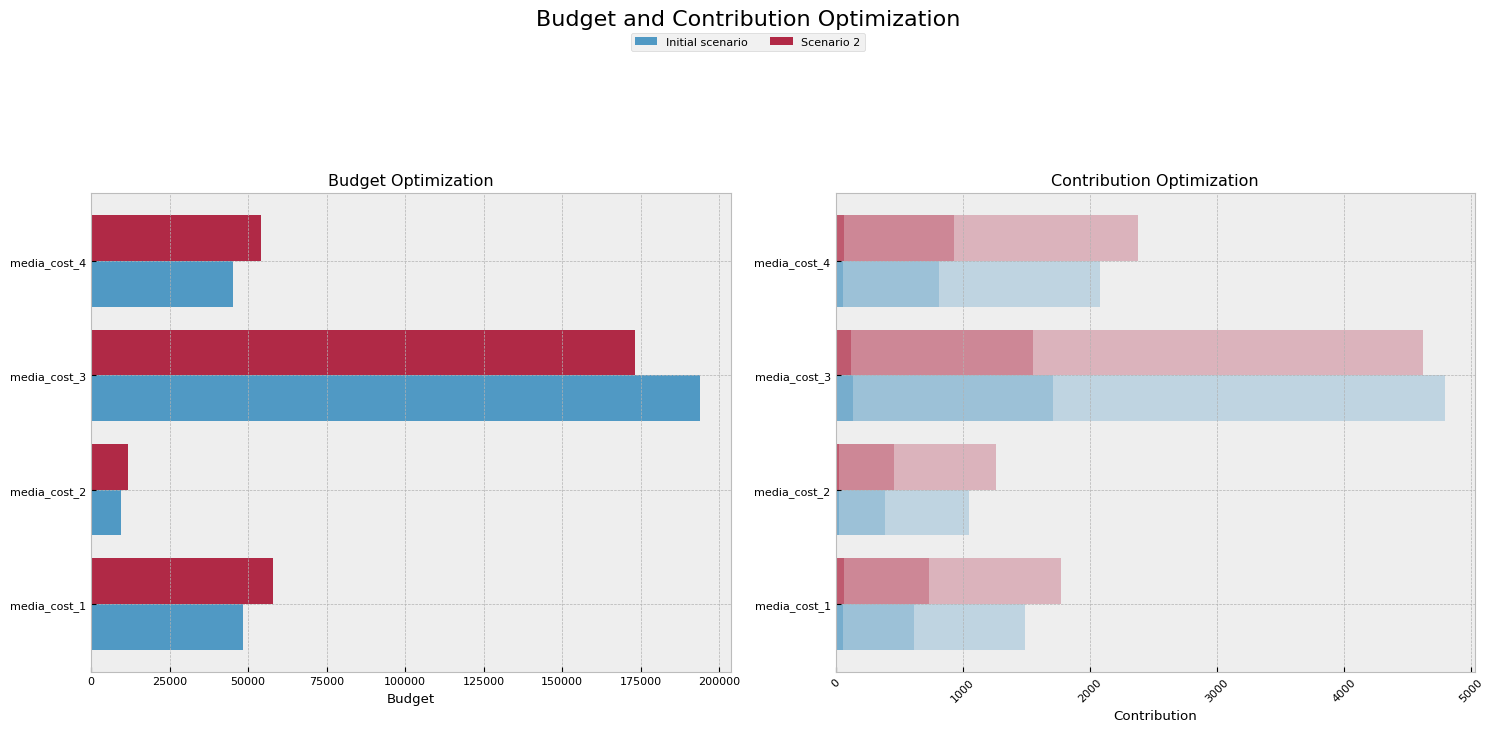

In [36]:
optimize_marketing_budget(driver.model, driver.processed_data, driver.config, driver.results_dir)

## Zip and download files

In [39]:
import os
from google.colab import files

def download_results_folder(folder_path='/content/results', zip_name='results.zip', exclude_patterns=None):
    """
    Download contents of a folder as a zip file, with optional exclusions.

    Args:
        folder_path (str): Path to the folder to zip
        zip_name (str): Name of the output zip file
        exclude_patterns (list): List of patterns to exclude, e.g., ['*/sample_data/*']
    """
    if exclude_patterns is None:
        exclude_patterns = []

    # Build the exclusion part of the command
    exclusion_str = ' '.join(f"-x '{pattern}'" for pattern in exclude_patterns)

    # Build the full zip command
    command = f"zip -r {zip_name} {folder_path} {exclusion_str}"

    # Run the command to create the zip file
    os.system(command)

    # Download the created zip file
    files.download(zip_name)

# Example usage:
exclusions = [
    '*/sample_data/*',  # Exclude sample_data folder and its contents
    '*.tmp',            # Exclude temporary files
    '*/.ipynb_checkpoints/*'  # Exclude Jupyter checkpoint folders
]

# Call the function with exclusions
download_results_folder(
    folder_path='/content',
    zip_name='content.zip',
    exclude_patterns=exclusions
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>